In [ ]:
from functions.functions import *
import torch
import matplotlib.pyplot as plt
import numpy as np
from functions.functions_time_model import *
from functions.functions_different_inputs import *

#import stuff from library
from functions.fno_wrapper import FNO1dWrapper as FNO1d
from neuralop import Trainer
from neuralop import LpLoss, H1Loss

# FNO - 1st architecture

## low energy states

In [ ]:
from functions.seed_utilis import *

seed=6
set_seed(seed) 

In [24]:
# Define parameters
N = 4  # Number of particles
num_states = 10000  # Number of input states
train_ratio = 0.8  # Ratio of training to testing data
batch_size=32
modes= (2**N)//2 #+1
hidden_channels=64
populated_states=3
times=3.14
hamiltonian= construct_hamiltonian(N)
steps=20

In [25]:
train_loader,test_loader=create_dataset_low_energy_states(N,num_states,train_ratio,batch_size,populated_states,times)

[Dataset] x_train: torch.Size([8000, 2, 16]), y_train: torch.Size([8000, 1, 16])
[Dataset] x_test: torch.Size([2000, 2, 16]), y_test: torch.Size([2000, 1, 16])


In [ ]:
model = FNO1d(n_modes_height=modes,
        hidden_channels=hidden_channels,
        in_channels=2,
        out_channels=1,
        complex=True)
model = model.to('cuda')

In [37]:
#optimizer = torch.optim.Adam(model.parameters(),lr=8e-3,weight_decay=1e-4)
optimizer = torch.optim.SGD(model.parameters(),
                            lr=10e-3,
                            momentum=0.9, 
                            weight_decay=1e-4)
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [38]:
#l2loss = LpLoss(d=2, p=2)
#h1loss = H1Loss(d=2)

#train_loss = h1loss
#eval_losses={'h1': h1loss, 'l2': l2loss}

In [39]:
l2loss = LpLoss(d=1, reduce_dims=[0, 1], p=2, reductions=['sum','mean'])
h1loss = H1Loss(d=1, reduce_dims=[0, 1],reductions=['sum','mean'])

def mse_loss(y_pred, y, **kwargs):
    assert y_pred.shape == y.shape
    assert y_pred.ndim == 3
    diff = (y_pred - y) 
    loss = (diff * diff.conj()).mean(dim=-1).sum(dim=[0])
    return loss.real

train_loss =  h1loss
eval_losses={'h1': h1loss, 'l2': l2loss} # adding fidelity 

In [40]:

epochs=50
batch_size=32
device='cuda'

trainer = Trainer(model=model, n_epochs=epochs,
    device=device,
    data_processor=None,
    wandb_log=False,
    log_test_interval=1, # log at every epoch
    use_distributed=False,
    verbose=True)

print(trainer)
trainer.train(train_loader=train_loader,
    test_loaders={"test_loader": test_loader},
    optimizer=optimizer,
    scheduler=scheduler,
    regularizer=False,
    training_loss=train_loss,
    eval_losses=eval_losses,)

self.override_load_to_device=False
self.overrides_loss=False


{'test_loader_h1': 0.004147091177292168,
 'test_loader_l2': 0.004164199396036565}

[Dataset] x_train: torch.Size([800, 2, 16]), y_train: torch.Size([800, 1, 16])
[Dataset] x_test: torch.Size([200, 2, 16]), y_test: torch.Size([200, 1, 16])
(200, 16)


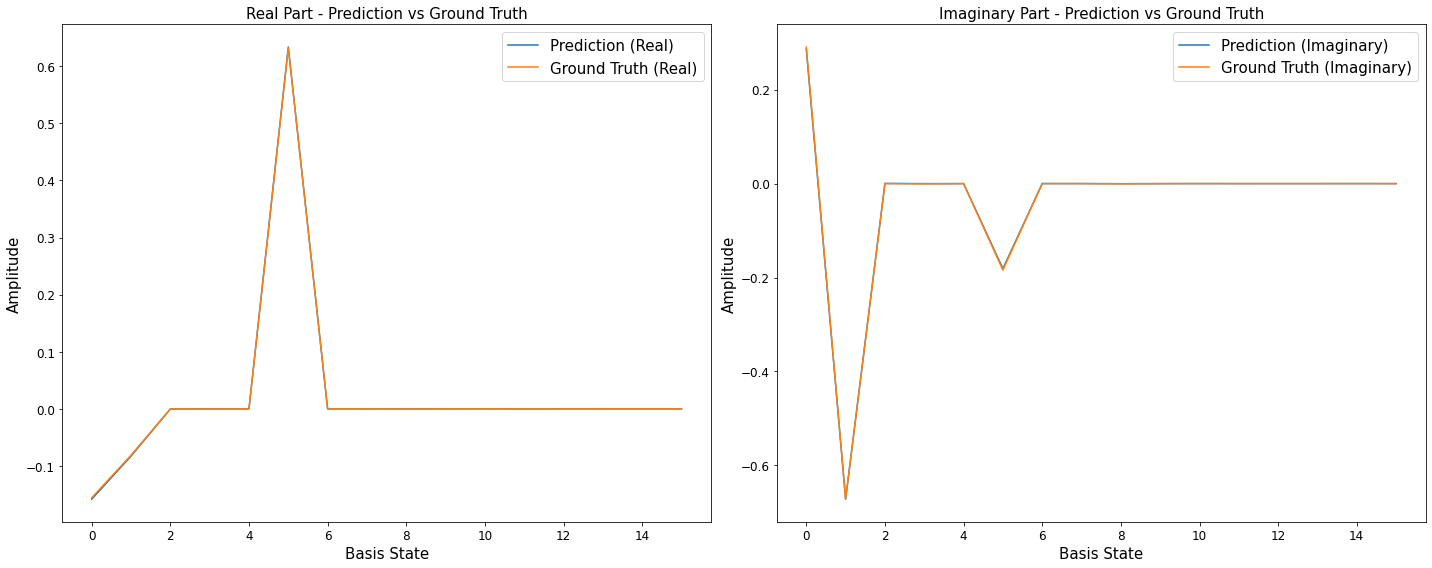

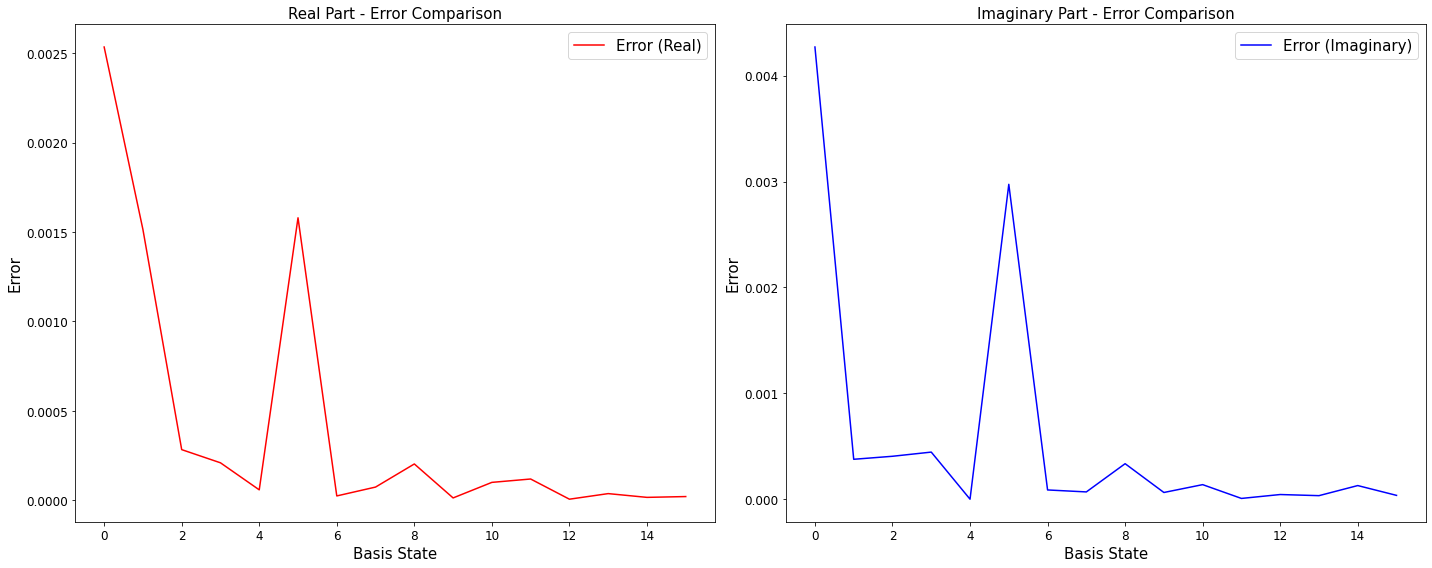

In [41]:
N = 4  # Number of particles
num_states = 1000  # Number of input states
train_ratio = 0.8  # Ratio of training to testing data
batch_size = 5
populated_states=3
_, test_loader = create_dataset_low_energy_states(N, num_states, train_ratio, batch_size,populated_states)
# Assuming `test_loader` is already defined
# Iterate through the test dataset and perform inference
predictions_list = []
ground_truth_list = []
for batch in test_loader:
    x, y = batch['x'].cuda(), batch['y'].cuda()  # Move data to GPU if available
    with torch.no_grad():
        predictions = model(x)  # Perform inference without gradient computation
    predictions_list.append(predictions.squeeze().cpu().numpy())
    ground_truth_list.append(y.squeeze().cpu().numpy())

# Concatenate predictions and ground truth across batches
predictions = np.concatenate(predictions_list)
ground_truth = np.concatenate(ground_truth_list)

print(ground_truth.shape)
# Plot the comparison with error
plot_comparison_with_error(predictions[0], ground_truth[0])  # Plot for the first sample in the dataset


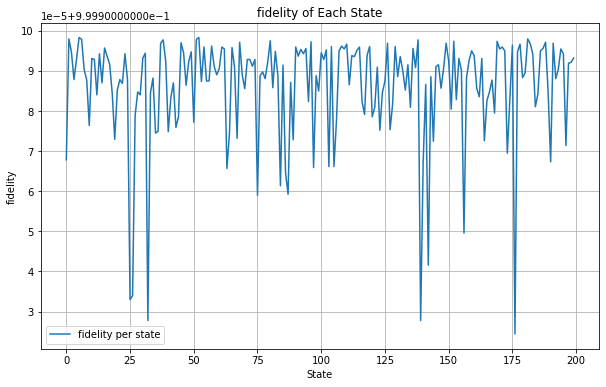

Mean fidelity is 0.9999861211509032


In [42]:



fidelity_vec = []
for i in range(len(predictions)):  # Iterate over the length of predictions
    fid = fidelity_state(predictions[i], ground_truth[i])
    fidelity_vec.append(fid)


# Calculate total MSE
total_fidelity = np.mean(fidelity_vec) 

plt.figure(figsize=(10, 6))
plt.plot(fidelity_vec, label='fidelity per state')
plt.xlabel('State')
plt.ylabel('fidelity')
plt.title('fidelity of Each State')
plt.legend()
plt.grid(True)
plt.show()

print("Mean fidelity is", total_fidelity)


## Autoregressive rollout

In [43]:
# Example usage
N = 4  # Number of particles
num_states = 1000  # Number of input states
train_ratio = 0.8  # Ratio of training to testing data
batch_size = 5
populated_states=3

rollout_steps = 10  # Number of autoregressive rollout steps

spatial_grid = torch.linspace(0, 1, 2**N).unsqueeze(0).expand(batch_size, -1).cuda()

# Define evolution times
times =  3.14

# Construct Hamiltonian
hamiltonian=construct_hamiltonian(N)
index,_=ordered_indices(N,hamiltonian)
hamiltonian2= order_hamiltonian(hamiltonian,index)
_,test_loader=create_dataset_low_energy_states(N,num_states,train_ratio,batch_size,populated_states,times)
predictions, ground_truth = autoregressive_rollout(model,test_loader,rollout_steps,spatial_grid,hamiltonian2.cuda(),times)


[Dataset] x_train: torch.Size([800, 2, 16]), y_train: torch.Size([800, 1, 16])
[Dataset] x_test: torch.Size([200, 2, 16]), y_test: torch.Size([200, 1, 16])


In [44]:
#flattening the tensor from eg: [10,200,16] to [2000,16]
predictions_final = predictions.view(-1, predictions.size(-1))
ground_truth_final=ground_truth.view(-1,ground_truth.size(-1))

# Convert to NumPy array
predictions_numpy = predictions_final.cpu().numpy()
ground_truth_numpy=ground_truth_final.cpu().numpy()
print(predictions_numpy.shape)
print(ground_truth_numpy.shape)

(2000, 16)
(2000, 16)


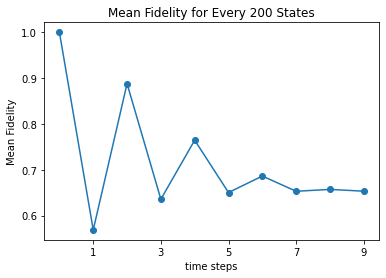

Total Mean Fidelity: 0.715734320034197


In [45]:
# Calculate fidelities for each pair of states
fidelities = []
test_states=num_states-int(num_states*train_ratio)
range_len= int(rollout_steps*(test_states))
for i in range(range_len):
    fid = fidelity_state(predictions_numpy[i], ground_truth_numpy[i])
    fidelities.append(fid)

# Calculate mean fidelity for every 200 states
mean_fidelities_len = []
for i in range(0, range_len, test_states):
    mean_fidelity = np.mean(fidelities[i:i+test_states])
    mean_fidelities_len.append(mean_fidelity)

# Calculate total mean fidelity
total_mean_fidelity = np.mean(fidelities)

# Plot mean fidelity for every 200 states
plt.plot(mean_fidelities_len, marker='o')
plt.xlabel('time steps')
plt.ylabel('Mean Fidelity')
plt.xticks([1,3,5,7,9]) #change this for different rollout steps
plt.title(f'Mean Fidelity for Every {test_states} States')
plt.show()

print("Total Mean Fidelity:", total_mean_fidelity)

## States ordered by population

In [39]:
# Define parameters
N = 4  # Number of particles
num_states = 10000  # Number of input states
train_ratio = 0.8  # Ratio of training to testing data
batch_size=32
modes= (2**N)//2 #+1
hidden_channels=64

In [40]:
train_loader,test_loader=create_dataset_sorted_by_population(N,num_states,train_ratio,batch_size)

[Dataset] x_train: torch.Size([8000, 2, 16]), y_train: torch.Size([8000, 1, 16])
[Dataset] x_test: torch.Size([2000, 2, 16]), y_test: torch.Size([2000, 1, 16])


In [41]:
model = FNO1d(n_modes_height=modes,
        hidden_channels=hidden_channels,
        in_channels=2,
        out_channels=1,
        spatial_domain= 'complex')
model = model.to('cuda')

In [42]:
optimizer = torch.optim.Adam(model.parameters(),
                                lr=8e-3,
                                weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)

In [43]:
l2loss = LpLoss(d=2, p=2)
h1loss = H1Loss(d=2)

train_loss = h1loss
eval_losses={'h1': h1loss, 'l2': l2loss}

In [44]:

epochs=50
batch_size=32
device='cuda'

trainer = Trainer(model=model, n_epochs=epochs,
    device=device,
    data_processor=None,
    wandb_log=False,
    log_test_interval=1, # log at every epoch
    use_distributed=False,
    verbose=True)

print(trainer)
trainer.train(train_loader=train_loader,
    test_loaders={"test_loader": test_loader},
    optimizer=optimizer,
    scheduler=scheduler,
    regularizer=False,
    training_loss=train_loss,
    eval_losses=eval_losses,)

self.override_load_to_device=False
self.overrides_loss=False


{'test_loader_h1': 0.026371651709079742,
 'test_loader_l2': 0.027844658240675925}

[Dataset] x_train: torch.Size([800, 2, 16]), y_train: torch.Size([800, 1, 16])
[Dataset] x_test: torch.Size([200, 2, 16]), y_test: torch.Size([200, 1, 16])
(200, 16)


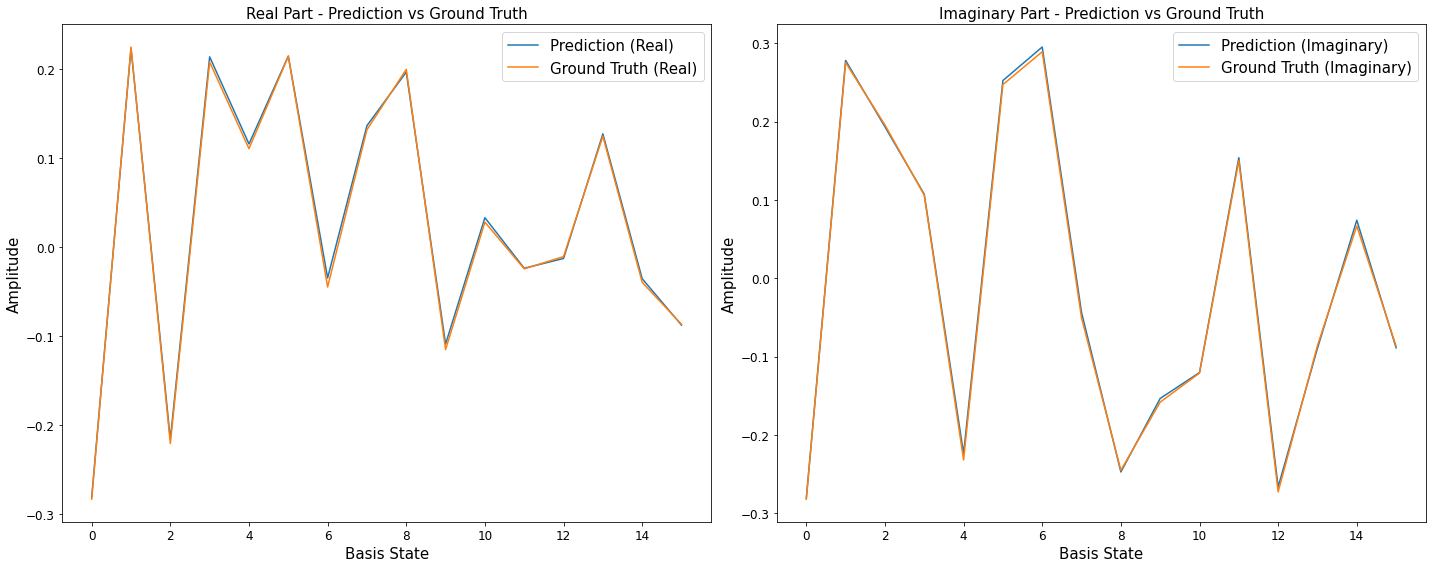

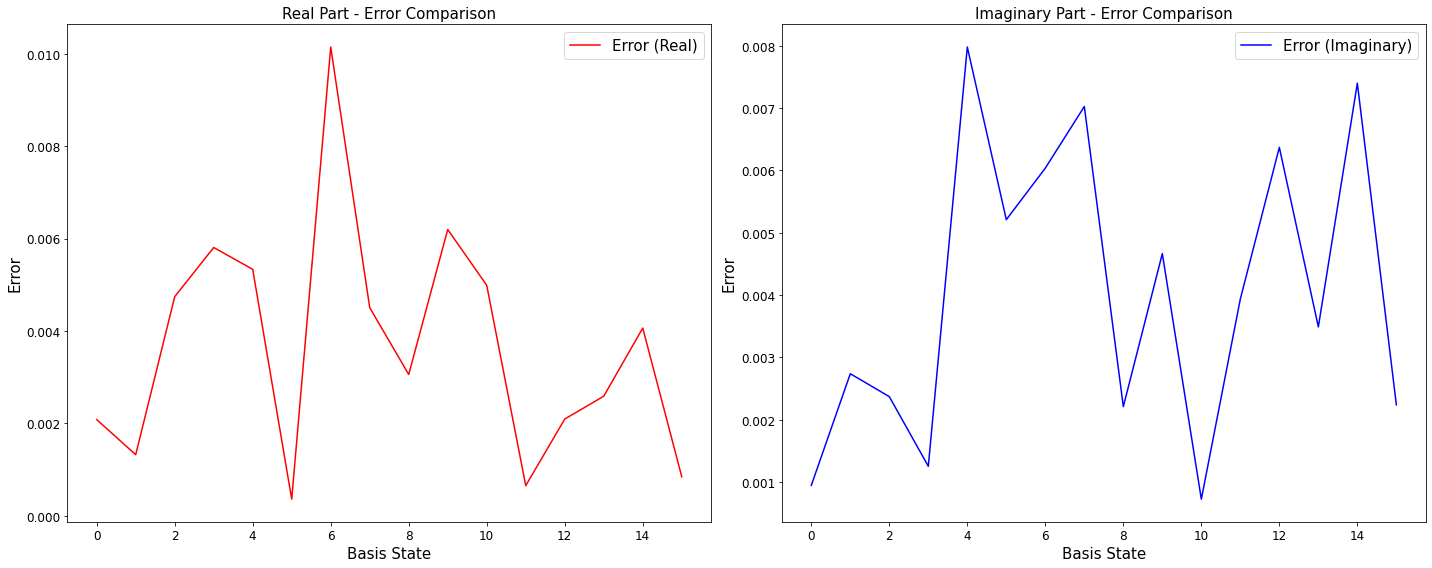

In [45]:
N = 4  # Number of particles
num_states = 1000  # Number of input states
train_ratio = 0.8  # Ratio of training to testing data
batch_size = 5

_, test_loader = create_dataset_sorted_by_population(N, num_states, train_ratio, batch_size)
# Assuming `test_loader` is already defined
# Iterate through the test dataset and perform inference
predictions_list = []
ground_truth_list = []
for batch in test_loader:
    x, y = batch['x'].cuda(), batch['y'].cuda()  # Move data to GPU if available
    with torch.no_grad():
        predictions = model(x)  # Perform inference without gradient computation
    predictions_list.append(predictions.squeeze().cpu().numpy())
    ground_truth_list.append(y.squeeze().cpu().numpy())

# Concatenate predictions and ground truth across batches
predictions = np.concatenate(predictions_list)
ground_truth = np.concatenate(ground_truth_list)

print(ground_truth.shape)
# Plot the comparison with error
plot_comparison_with_error(predictions[0], ground_truth[0])  # Plot for the first sample in the dataset


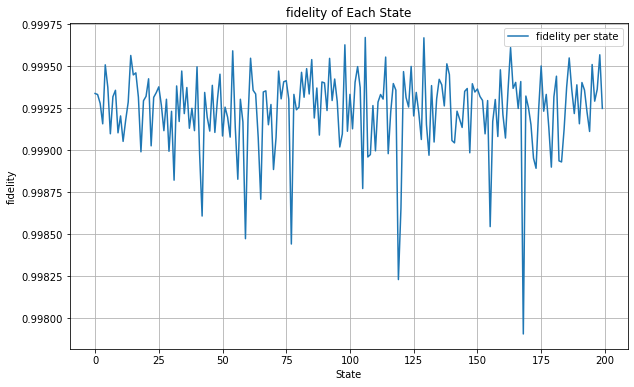

Mean fidelity is 0.9992353455543233


In [46]:



fidelity_vec = []
for i in range(len(predictions)):  # Iterate over the length of predictions
    fid = fidelity_state(predictions[i], ground_truth[i])
    fidelity_vec.append(fid)


# Calculate total MSE
total_fidelity = np.mean(fidelity_vec) 

plt.figure(figsize=(10, 6))
plt.plot(fidelity_vec, label='fidelity per state')
plt.xlabel('State')
plt.ylabel('fidelity')
plt.title('fidelity of Each State')
plt.legend()
plt.grid(True)
plt.show()

print("Mean fidelity is", total_fidelity)


## Autoregressive rollout

In [47]:
# Example usage
N = 4  # Number of particles
num_states = 1000  # Number of input states
train_ratio = 0.8  # Ratio of training to testing data
batch_size = 5

rollout_steps = 10  # Number of autoregressive rollout steps

spatial_grid = torch.linspace(0, 1, 2**N).unsqueeze(0).expand(batch_size, -1).cuda()

# Define evolution times
times =  3.14

# Construct Hamiltonian
hamiltonian=construct_hamiltonian(N)
index,_=ordered_indices(N,hamiltonian)
hamiltonian2= order_hamiltonian(hamiltonian,index)
_,test_loader=create_dataset_sorted_by_population(N,num_states,train_ratio,batch_size,times)
predictions, ground_truth = autoregressive_rollout(model,test_loader, rollout_steps,spatial_grid,hamiltonian2.cuda(),times)


[Dataset] x_train: torch.Size([800, 2, 16]), y_train: torch.Size([800, 1, 16])
[Dataset] x_test: torch.Size([200, 2, 16]), y_test: torch.Size([200, 1, 16])


In [48]:
#flattening the tensor from eg: [10,200,16] to [2000,16]
predictions_final = predictions.view(-1, predictions.size(-1))
ground_truth_final=ground_truth.view(-1,ground_truth.size(-1))

# Convert to NumPy array
predictions_numpy = predictions_final.cpu().numpy()
ground_truth_numpy=ground_truth_final.cpu().numpy()
print(predictions_numpy.shape)
print(ground_truth_numpy.shape)

(2000, 16)
(2000, 16)


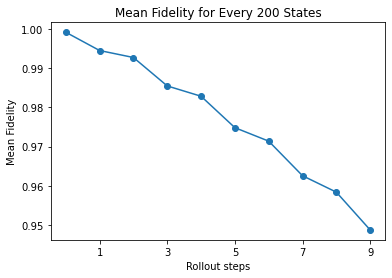

Total Mean Fidelity: 0.977066417223641


In [49]:
# Calculate fidelities for each pair of states
fidelities = []
test_states=num_states-int(num_states*train_ratio)
range_len= int(rollout_steps*(test_states))
for i in range(range_len):
    fid = fidelity_state(predictions_numpy[i], ground_truth_numpy[i])
    fidelities.append(fid)

# Calculate mean fidelity for every 200 states
mean_fidelities_len = []
for i in range(0, range_len, test_states):
    mean_fidelity = np.mean(fidelities[i:i+test_states])
    mean_fidelities_len.append(mean_fidelity)

# Calculate total mean fidelity
total_mean_fidelity = np.mean(fidelities)

# Plot mean fidelity for every 200 states
plt.plot(mean_fidelities_len, marker='o')
plt.xlabel('Rollout steps')
plt.ylabel('Mean Fidelity')
plt.xticks([1,3,5,7,9]) #change this for different rollout steps
plt.title(f'Mean Fidelity for Every {test_states} States')
plt.show()

print("Total Mean Fidelity:", total_mean_fidelity)